## PROBLEM STATEMENT

<p> A bank has various information of around 10000 customers which also indetifies if the bank lost the customer or not. Our task is to build a ML model such that we can predict if a customer is going to churn or not.</p>

<div><h4 style="font-family:verdana;">Columns:</h4>

<ol>
    <li><code style="font-family:verdana;">customer_id</code> - Unique ID for a particular customer.</li>
    <li><code style="font-family:verdana;">credit_score</code> - Score which determines the creditworthiness of a customer.</li>
    <li><code style="font-family:verdana;">country</code> - Country of the customer.</li>
    <li><code style="font-family:verdana;">gender</code> - Sex of customer.</li>
    <li><code style="font-family:verdana;">age</code> - Age of customer.</li>
    <li><code style="font-family:verdana;">tenure</code> - Number of years the customer has Bank Account.</li>
    <li><code style="font-family:verdana;">balance</code> - Amount present in customer's bank account.</li>
    <li><code style="font-family:verdana;">products_number</code> - Number of Products from that Bank.</li>
    <li><code style="font-family:verdana;">credit_card</code> - If the customer owns a credit card.</li>
    <li><code style="font-family:verdana;">active_member</code> - Whether the customer is an active member or not.</li>
    <li><code style="font-family:verdana;">estimated_salary</code> - Income of the Customer.</li>
    <li><code style="font-family:verdana;">churn</code> - Churn (Loss of existing customers) of the Bank. 1 if the client has left the bank during some period or 0 if he/she has not.</li>
</ol>
</div>

## IMPORT REQUIRED LIBRARIES

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif



## READ DATASET

In [ ]:
df=pd.read_csv("Bank Customer Churn Prediction.csv")
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## PRIMARY ANALYSIS OF THE DATA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


**Note: There are two categorical columns - country & gender. The rest of the columns are numerical.**

In [ ]:
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

In [ ]:
# Null Values
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

**Note: We do not have any missing values in the dataset**

## CONVERT CATEGORICAL COLUMNS TO NUMERICAL 

In [ ]:
country_dummies=pd.get_dummies(df['country'])
df["gender"]=df["gender"].replace({"Male": 1, "Female": 0})


In [ ]:
df_encoded=pd.concat([df,country_dummies],axis=1)
df_encoded.drop(['customer_id', 'country'], axis=1,inplace=True)
df_encoded.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1


## EXPLORE THE RELATIONSHIPS IN THE DATA

In [ ]:
df_encoded.describe()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.501400,0.250900,0.247700
std,96.653299,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.500023,0.433553,0.431698
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,1.000000,0.000000,0.000000
75%,718.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,1.000000,0.000000
max,850.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_encoded.corr()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain
credit_score,1.000000,-0.002857,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,-0.008928,0.005538,0.004780
gender,-0.002857,1.000000,-0.027544,0.014733,0.012087,-0.021859,0.005766,0.022544,-0.008112,-0.106512,0.006772,-0.024628,0.016889
age,-0.003965,-0.027544,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,-0.039208,0.046897,-0.001685
tenure,0.000842,0.014733,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001,-0.002848,-0.000567,0.003868
balance,0.006268,0.012087,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,-0.231329,0.401110,-0.134892
products_number,0.012238,-0.021859,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,0.001230,-0.010419,0.009039
credit_card,-0.005458,0.005766,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.002467,0.010577,-0.013480
active_member,0.025651,0.022544,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,0.003317,-0.020486,0.016732
estimated_salary,-0.001384,-0.008112,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,-0.003332,0.010297,-0.006482
churn,-0.027094,-0.106512,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,-0.104955,0.173488,-0.052667


In [ ]:
# move the target variable (churn) to last column
cols = list(df_encoded.columns.values)
cols.pop(cols.index('churn'))
df_rearranged = df_encoded[cols+['churn']]
df_rearranged.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,France,Germany,Spain,churn
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0,1
3,699,0,39,1,0.00,2,0,0,93826.63,1,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1,0


## EXPLORE THE EFFECT OF FEATURES ON THE TARGET VARIABLE (churn)

<AxesSubplot:>

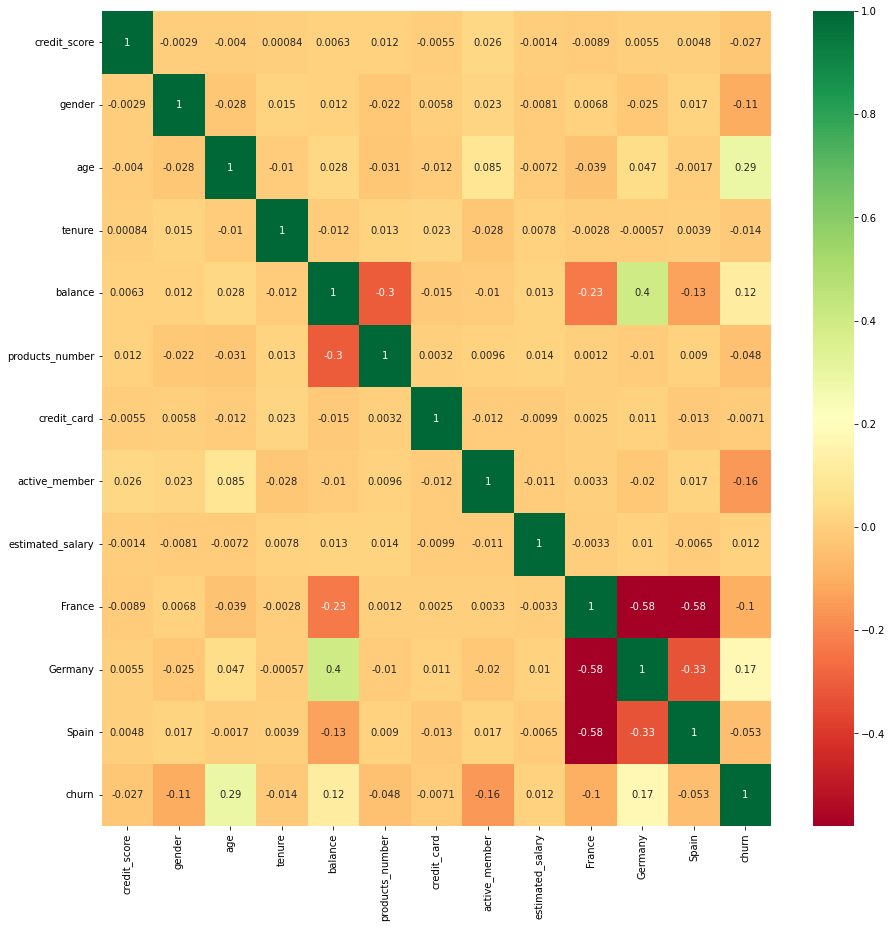

In [ ]:
# get heatmap for each features
corrmat = df_rearranged.corr()
corr_features = corrmat.index
plt.figure(figsize=(15,15))
sns.heatmap(df_rearranged[corr_features].corr(), annot=True, cmap='RdYlGn')

**Note**: So from heat map we see that the features that has highest impact on the target variable are:

1. age
2. Germany
3. active_member
4. balance
5. gender
6. France
7. Spain


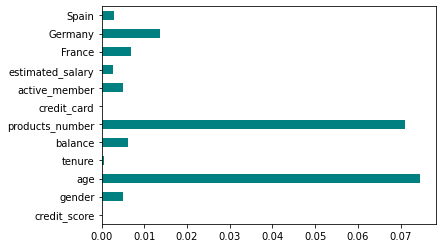

In [ ]:
X = df_rearranged.iloc[:, :-1]
y = df_rearranged.iloc[:, -1]

importances = mutual_info_classif(X,y)
feat_importances = pd.Series(importances, df_rearranged.columns[:-1])
feat_importances.plot(kind='barh', color='teal')
plt.show()

**Note:** So from mututal information plot, we can see the features that has highest impact on the target variable:

1. age
2. products_number
3. Germany
4. active_member
5. balance
6. France
7. gender




## TEST THE PERFORMANCE OF EACH CLASSIFIER ON THE DATASET

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), SGDClassifier(), SVC()]
models_string = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'SGDClassifier', 'SVC',]


LR_accuracies = []
DT_accuracies = []
RF_accuracies = []
SGD_accuracies = []
SVC_accuracies = []

def append_accuracy(model_string, scores):        
    match model_string:
        case 'LogisticRegression':
            LR_accuracies.append(round(np.mean(scores), 6))
        case 'DecisionTreeClassifier':
            DT_accuracies.append(round(np.mean(scores), 6))
        case 'RandomForestClassifier':
            RF_accuracies.append(round(np.mean(scores), 6))
        case 'SGDClassifier':
            SGD_accuracies.append(round(np.mean(scores), 6))
        case 'SVC':
            SVC_accuracies.append(round(np.mean(scores), 6))

    

In [ ]:
print("==================Testing initial accuracies =============")

algo_accuracy = {}

for m, m_s in zip(models, models_string):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=25)
    scores = cross_val_score(m, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    acc = round(np.mean(scores), 6)
    
    print(f"Model: {m_s} >> Accuracy: {acc}")
    
    append_accuracy(m_s, scores)
    algo_accuracy[m_s] = acc
    

==================Testing initial accuracies =============
Model: LogisticRegression >> Accuracy: 0.790433
Model: DecisionTreeClassifier >> Accuracy: 0.789733
Model: RandomForestClassifier >> Accuracy: 0.8603
Model: SGDClassifier >> Accuracy: 0.702333
Model: SVC >> Accuracy: 0.7963


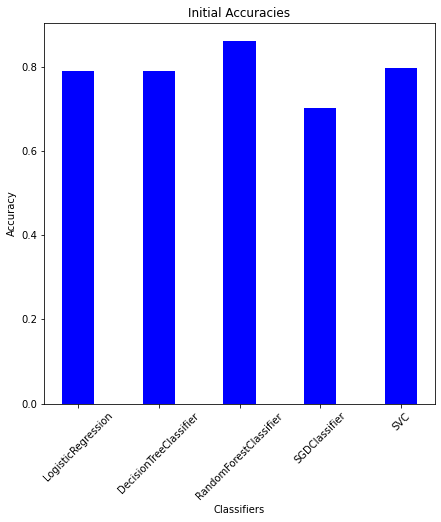

In [ ]:
# plot the result
clsf = list(algo_accuracy.keys())
result = list(algo_accuracy.values())
  
fig = plt.figure(figsize = (7, 7))

plt.bar(clsf, result, color ='blue', width = 0.4)
plt.xticks(range(len(clsf)), clsf, rotation=45)
 
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Initial Accuracies")
plt.show()

**Remark:**  
We can see that RandomForestClassifier has the highest accuracy while SGDClassifier has the lowest

## TEST THE PERFORMANCES AFTER SCALING THE DATA

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler().fit(X)
X_scaled=scaler.transform(X)
X_scaled


array([[0.538     , 0.        , 0.32432432, ..., 1.        , 0.        ,
        0.        ],
       [0.516     , 0.        , 0.31081081, ..., 0.        , 0.        ,
        1.        ],
       [0.304     , 0.        , 0.32432432, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.718     , 0.        , 0.24324324, ..., 1.        , 0.        ,
        0.        ],
       [0.844     , 1.        , 0.32432432, ..., 0.        , 1.        ,
        0.        ],
       [0.884     , 0.        , 0.13513514, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
print("==================Testing with scaled features =============")

algo_accuracy = {}

for m, m_s in zip(models, models_string):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=25)
    scores = cross_val_score(m, X_scaled, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    acc = round(np.mean(scores), 6)    
    print(f"Model: {m_s} >> Accuracy: {acc}")
    
    append_accuracy(m_s, scores)
    algo_accuracy[m_s] = acc

==================Testing with scaled features =============
Model: LogisticRegression >> Accuracy: 0.810833
Model: DecisionTreeClassifier >> Accuracy: 0.788867
Model: RandomForestClassifier >> Accuracy: 0.861833
Model: SGDClassifier >> Accuracy: 0.796333
Model: SVC >> Accuracy: 0.8393


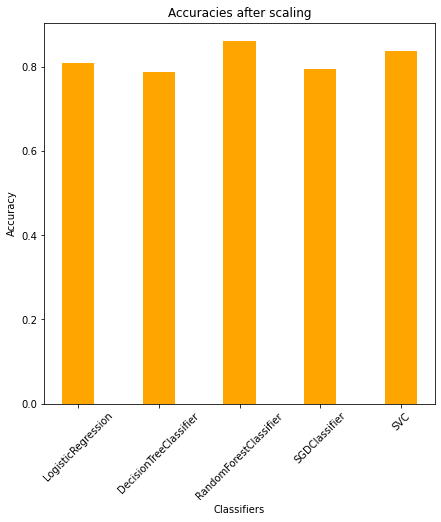

In [ ]:
# plot the result
clsf = list(algo_accuracy.keys())
result = list(algo_accuracy.values())
  
fig = plt.figure(figsize = (7, 7))

plt.bar(clsf, result, color ='orange', width = 0.4)
plt.xticks(range(len(clsf)), clsf, rotation=45)
 
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Accuracies after scaling")
plt.show()

**Remark:**  
We can see that scaling the data increases accuracy

## TEST THE PERFORMANCES AFTER STANDARDIZATION OF THE DATA

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_scaled)
X_standard = scaler.transform(X_scaled)
X_standard


array([[-0.32622142, -1.09598752,  0.29351742, ...,  0.99720391,
        -0.57873591, -0.57380915],
       [-0.44003595, -1.09598752,  0.19816383, ..., -1.00280393,
        -0.57873591,  1.74273971],
       [-1.53679418, -1.09598752,  0.29351742, ...,  0.99720391,
        -0.57873591, -0.57380915],
       ...,
       [ 0.60498839, -1.09598752, -0.27860412, ...,  0.99720391,
        -0.57873591, -0.57380915],
       [ 1.25683526,  0.91241915,  0.29351742, ..., -1.00280393,
         1.72790383, -0.57380915],
       [ 1.46377078, -1.09598752, -1.04143285, ...,  0.99720391,
        -0.57873591, -0.57380915]])

In [ ]:
print("==================Testing with Standardized features =============")

algo_accuracy = {}

for m, m_s in zip(models, models_string):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=25)
    scores = cross_val_score(m, X_standard, y, scoring='accuracy', cv=cv, n_jobs=-1)
            
    acc = round(np.mean(scores), 6)    
    print(f"Model: {m_s} >> Accuracy: {acc}")
    
    append_accuracy(m_s, scores)
    algo_accuracy[m_s] = acc

==================Testing with Standardized features =============
Model: LogisticRegression >> Accuracy: 0.809833
Model: DecisionTreeClassifier >> Accuracy: 0.789267
Model: RandomForestClassifier >> Accuracy: 0.860967
Model: SGDClassifier >> Accuracy: 0.799467
Model: SVC >> Accuracy: 0.8557


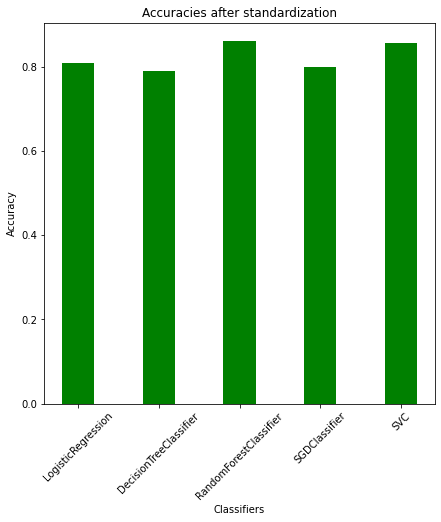

In [ ]:
# plot the result
clsf = list(algo_accuracy.keys())
result = list(algo_accuracy.values())
  
fig = plt.figure(figsize = (7, 7))

plt.bar(clsf, result, color ='green', width = 0.4)
plt.xticks(range(len(clsf)), clsf, rotation=45)
 
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Accuracies after standardization")
plt.show()

**Remark:**  
We can see that Standardizing the data didn't have remarkable impact on the accuracies.

## TEST WITH GridSearchCV TO FIND THE BEST PERFORMING HYPERPARAMETER COMBINATIONS

In [ ]:
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


models = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, SGDClassifier, SVC]
models_string = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'SGDClassifier', 'SVC',]
models_hyper_params = [{'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.1,1, 10, 100, 1000], 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
                       {"criterion": ['gini', 'entropy'], 'splitter': ["random","best"], 'min_samples_split':[2,5]},
                       {"n_estimators": [10,50,100], "criterion": ['gini', 'entropy'],"max_features": ["auto","sqrt"], 'bootstrap' : [True, False],'min_samples_leaf' : [1, 2, 4],'max_depth':[2,5,10,15]},
                       {'loss': ['hinge', 'log', 'modified_huber'],'alpha': [0.0001,0.001,0.01],'penalty':["l2","l1"]},
                       {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1], 'kernel': ['linear', 'poly', 'rbf']}]

print("================== Tuning for hyperparameters of the models =============")

for m, m_s, m_hp in zip(models, models_string, models_hyper_params):
    # find best param values for each model and check accuracies
    gs = GridSearchCV(m(),m_hp)
    gs.fit(X_scaled, y)
    m_best_params = gs.best_params_

    print(m_best_params)
    # initialize the classifiers with best parameters
    m_init = m(**m_best_params)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=25)
    scores = cross_val_score(m_init, X_scaled, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    print(f"Model: {m_s} >> Accuracy: {round(np.mean(scores), 6)}")
    print("\n")
    
    append_accuracy(m_s, scores)



================== Tuning for hyperparameters of the models =============
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Model: LogisticRegression >> Accuracy: 0.812167


{'criterion': 'gini', 'min_samples_split': 5, 'splitter': 'random'}
Model: DecisionTreeClassifier >> Accuracy: 0.812867


{'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
Model: RandomForestClassifier >> Accuracy: 0.864533


{'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}
Model: SGDClassifier >> Accuracy: 0.810433


{'C': 100, 'gamma': 1, 'kernel': 'poly'}
Model: SVC >> Accuracy: 0.861167




## TEST THE PERFORMANCE AFTER DROPPING COLUMNS

**We have seen earlier that credit_card, estimated_salary, tenure & credit_score have weak relation to the target variable. So we are going to drop these features and test the impact.**

In [ ]:
df_selected = df_rearranged.drop(['credit_card', 'estimated_salary', 'tenure', 'credit_score'], axis=1)
X_selected = df_selected.iloc[:, :-1]
y = df_selected.iloc[:, -1]

In [ ]:
scaler=MinMaxScaler().fit(X_selected)
X_selected_scaled=scaler.transform(X_selected)

In [ ]:
print("================== Testing accuracy after dropping columns =============")

for m, m_s, m_hp in zip(models, models_string, models_hyper_params):
    # find best param values for each model and check accuracies
    gs = GridSearchCV(m(),m_hp)
    gs.fit(X_selected_scaled, y)
    m_best_params = gs.best_params_

    print(m_best_params)
    # initialize the classifiers with best parameters
    m_init = m(**m_best_params)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=25)
    scores = cross_val_score(m_init, X_selected_scaled, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    print(f"Model: {m_s} >> Accuracy: {round(np.mean(scores), 6)}")
    print("\n")
    
    append_accuracy(m_s, scores)

================== Testing accuracy after dropping columns =============
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Model: LogisticRegression >> Accuracy: 0.8118


{'criterion': 'entropy', 'min_samples_split': 5, 'splitter': 'random'}
Model: DecisionTreeClassifier >> Accuracy: 0.830567


{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 100}
Model: RandomForestClassifier >> Accuracy: 0.862


{'alpha': 0.001, 'loss': 'log', 'penalty': 'l1'}
Model: SGDClassifier >> Accuracy: 0.8108


{'C': 100, 'gamma': 1, 'kernel': 'poly'}
Model: SVC >> Accuracy: 0.8593




In [ ]:
print("LR_accuracies = ", LR_accuracies)
print("DT_accuracies = ", DT_accuracies)
print("RF_accuracies = ", RF_accuracies)
print("SGD_accuracies = ", SGD_accuracies)
print("SVC_accuracies = ", SVC_accuracies)


LR_accuracies =  [0.790433, 0.810833, 0.809833, 0.812167, 0.8118]
DT_accuracies =  [0.789733, 0.788867, 0.789267, 0.812867, 0.830567]
RF_accuracies =  [0.8603, 0.861833, 0.860967, 0.864533, 0.862]
SGD_accuracies =  [0.702333, 0.796333, 0.799467, 0.810433, 0.8108]
SVC_accuracies =  [0.7963, 0.8393, 0.8557, 0.861167, 0.8593]


## COMPARE THE ACCURACIES OBTAINED IN EACH STEP FOR ALL THE CLASSIFIERS

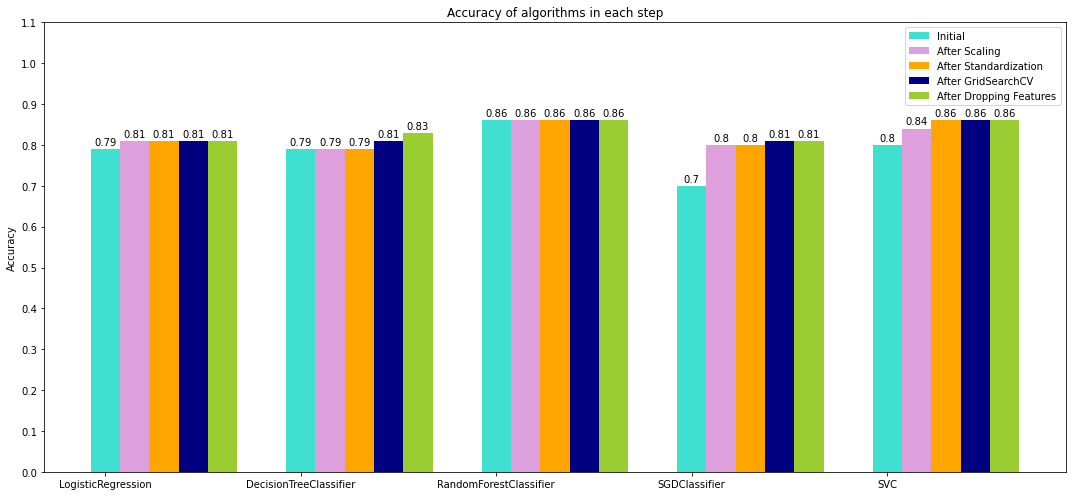

In [ ]:
# Now we will plot the accuracies obtained in each step

labels = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'SGDClassifier', 'SVC']

STEPS =  []

for lr,dt,rf,sgd,svc in zip(LR_accuracies,DT_accuracies, RF_accuracies, SGD_accuracies, SVC_accuracies):
    STEPS.append(np.round([lr,dt,rf,sgd,svc], 2))

step_initial = STEPS[0]
step_scaled = STEPS[1]
step_stand = STEPS[2]
step_gridsearch = STEPS[3]
step_drop_column = STEPS[4]


index = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 7))

rects1 = ax.bar(index, step_initial, width, label='Initial', color='turquoise')
rects2 = ax.bar(index + width, step_scaled, width, label='After Scaling', color='plum')
rects3 = ax.bar(index + width*2, step_stand, width, label='After Standardization', color='orange')
rects4 = ax.bar(index + width*3, step_gridsearch, width, label='After GridSearchCV', color='navy')
rects5 = ax.bar(index + width*4, step_drop_column, width, label='After Dropping Features', color='yellowgreen')


ax.set_title('Accuracy of algorithms in each step')
ax.set_xticks(index, labels)
ax.set_ylabel('Accuracy')
ax.set_yticks(np.arange(0, 1.2, 0.1))
ax.legend()

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
ax.bar_label(rects5, padding=2)

fig.tight_layout()

plt.show()

**Findings:**  
- We can see that the best performing classifiers are **Random Forest(0.86)** and **SVC(0.86)**

- During the **GridSearchCV stage**  we found that there was 2.53% and 1.25% increase in accuracy for the **DecisionTreeClassifier** and the **SGDClassifier** respectively. 

- For **DecisionTreeClassifier** the best hyperparameter values were -   
'criterion': 'gini', 'min_samples_split': 5, 'splitter': 'random'

- For **SGDClassifier** the best hyperparameter values were -   
'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'

- After data processing and hyperparameter tuning the highest increase is found for **SGDClassifier**, where initial accuracy was **0.7** but in the final step it went up to **0.81**

- Dropping features didn't have significant impact on the accuracy for most classifiers except **DecisionTreeClassifier**, for which the value increased from **0.81** to **0.83**

